# Intro to Adversarial Attacks
Jupyter Notebook for Intel Software Workshop, Zurich on 17th May, 2018

Please see slides + other content at: https://github.com/gokul-uf/talks

In [1]:
# imports

import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf

import cleverhans
from cleverhans.attacks import FastGradientMethod
from cleverhans.model import CallableModelWrapper

from svhn_data_utils import SVHN_Processor

tf.set_random_seed(1234)
np.random.seed(1234)

## HParams

In [2]:
num_classes = 10  # digits 0-9
num_steps = 5000  # train model for 5k steps
eval_every = 100  # eval the performance every 100 steps
batch_size = 100  # number of images in a batch
img_dim = 32
img_channels = 3
attack_params = {
                    "eps": 0.2,
                    "ord": np.inf
                }

In [3]:
# batch generator
data_processor = SVHN_Processor("svhn/", batch_size)
train_yielder = data_processor.get_train_batch()
val_yielder = data_processor.get_val_batch()

In [4]:
def make_image_grid(images, num_rows):
    if img_channels > 1:
        images = images.reshape(batch_size, img_dim, img_dim, img_channels)
        images = images * 0.5 + 0.5
        images[images>1] = 1
        images[images<0] = 0
        cmap = None
    else:  # Black and White images
        images = images.reshape(batch_size, img_dim, img_dim)
        cmap = "gray"

    fig = plt.figure()
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_rows), axes_pad=0)
    for x in range(num_rows * num_rows):
        grid[x].imshow(images[x], cmap=cmap)
        grid[x].set_xticks([])
        grid[x].set_yticks([])
    plt.show()
#     plt.savefig(os.path.join(img_dir, filename))
    plt.close()

## Network Definition

In [5]:
def classifier(inputs, reuse=True):
    with tf.variable_scope("model", reuse = reuse):
        xav_init = tf.contrib.layers.xavier_initializer
        layer_1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], 
                                   padding="same",activation=tf.nn.relu,kernel_initializer=xav_init())
        layer_1 = tf.layers.max_pooling2d(layer_1, pool_size=[2, 2], strides=[2, 2])

        layer_2 = tf.layers.conv2d(inputs=layer_1, filters=64, kernel_size=[3, 3],
                                   padding="same", activation=tf.nn.relu, kernel_initializer=xav_init())
        layer_2 = tf.layers.max_pooling2d(layer_2, pool_size=[2, 2], strides=[2, 2])

        layer_3 = tf.layers.conv2d(inputs=layer_2, filters=128, kernel_size=[3, 3],
                                   padding="same", activation=tf.nn.relu, kernel_initializer=xav_init())
        layer_3 = tf.layers.max_pooling2d(layer_3, pool_size=[2, 2], strides=[2, 2])

        layer_4 = tf.layers.conv2d(inputs=layer_3, filters=256,kernel_size=[3, 3],
                                   padding="same", activation=tf.nn.relu, kernel_initializer=xav_init())
        layer_4 = tf.layers.max_pooling2d(layer_4, pool_size=[2, 2], strides=[2, 2])

        layer_5 = tf.layers.conv2d(inputs=layer_4, filters=512, kernel_size=[3, 3],
                                   padding="same", activation=tf.nn.relu, kernel_initializer=xav_init())
        layer_5 = tf.layers.max_pooling2d(layer_5, pool_size=[2, 2], strides=[2, 2])

        flatten_layer_5 = tf.contrib.layers.flatten(layer_5)
        logits = tf.layers.dense(inputs=flatten_layer_5, units=num_classes, name="logits")
    return logits

In [9]:
# placeholders
tf.reset_default_graph()
images = tf.placeholder(shape = [None, 32, 32, 3], dtype = tf.float32, name = "images")
labels = tf.placeholder(shape = [None, 10], dtype = tf.int32, name = "labels")

## Adversarial Attack using CleverHans

In [10]:
# add adversarial samples nodes in the graph
sess = tf.Session()

real_logits = classifier(images, reuse = False)
model = CallableModelWrapper(classifier, "logits")
fgsm = FastGradientMethod(model, sess = sess)

# also check out fgsm.generate_np
adv_images = fgsm.generate(images, **attack_params)

# logits and preds
real_logits = classifier(images)
adv_logits = classifier(adv_images)

real_preds = tf.nn.softmax(real_logits)
adv_preds = tf.nn.softmax(adv_logits)


# loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                        labels = labels,
                        logits = real_logits
                        )
cross_entropy = tf.reduce_mean(cross_entropy)

# accuracy
c_accuracy = tf.equal(tf.argmax(real_preds, 1), tf.argmax(labels, 1))
c_accuracy = tf.reduce_mean(tf.cast(c_accuracy, tf.float32))

adv_c_accuracy = tf.equal(tf.argmax(adv_preds, 1), tf.argmax(labels, 1))
adv_c_accuracy = tf.reduce_mean(tf.cast(adv_c_accuracy, tf.float32))

# optimizer
c_opt = tf.train.AdamOptimizer().minimize(cross_entropy)

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Training loop, skipped during the talk

In [ ]:
sess.run(tf.global_variables_initializer())
for i in range(num_steps):
    batch_images, batch_labels = next(train_yielder)
    sess.run(c_opt, feed_dict = {images: batch_images,
                                 labels: batch_labels})
    
    if i % eval_every == 0:
        try:
            batch_images, batch_labels = next(val_yielder)
        except StopIteration:
            print("Val set exhausted, looping...")
            val_yielder = data_processor.get_val_batch()
            batch_images, batch_labels = next(val_yielder)

        feed_dict = {
            images: batch_images,
            labels: batch_labels,
        }
        acc, loss = sess.run([c_accuracy, cross_entropy], feed_dict=feed_dict)
        print(f"step:  {i}, acc: {acc}, loss: {loss}")


## Loading and Saving

In [ ]:
# save model
saver = tf.train.Saver(max_to_keep=None)
saver.save(sess, os.path.join("saved_model", "saved_models.ckpt"))
print("Model Saved!")

In [11]:
# load model
saver = tf.train.Saver(max_to_keep=None)
print("Loading Weights...")
saver.restore(sess, os.path.join("saved_model", "saved_models.ckpt"))
print("Model Load Complete!")

Loading Weights...
INFO:tensorflow:Restoring parameters from saved_model/saved_models.ckpt
Model Load Complete!


## Attacks In Action

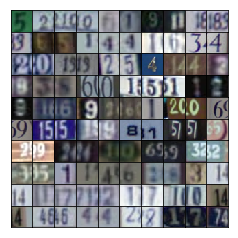

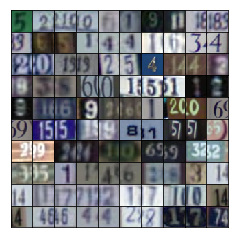

Real Acc: 0.8799999952316284, Adv Acc: 0.09000000357627869


In [12]:
attack_params = {
                    "eps":0.00001,
                    "ord": 2  # could be 1, 2 or np.inf
                }
adv_images = fgsm.generate(images, **attack_params)

# Generate adversarial samples
# sess.run(tf.global_variables_initializer())
batch_images, batch_labels = next(val_yielder)

real_acc = sess.run(c_accuracy, feed_dict = {images: batch_images, labels: batch_labels})
adv_acc, adv_imgs  = sess.run([adv_c_accuracy, adv_images], feed_dict= {images: batch_images, labels: batch_labels})

make_image_grid(batch_images, 10)
make_image_grid(adv_imgs, 10)

print(f"Real Acc: {real_acc}, Adv Acc: {adv_acc}")
